# Introduction
Point of this notebook is simply to observe (withotu any decision making) the performance across a matrix of window skips and window lengths

In [1]:
from sampleddetection.environment.datastructures import Action, State
from sampleddetection.environment.model import Environment
from sampleddetection.datastructures.flowsession import SampledFlowSession
import numpy as np
from typing import List
import os
from tqdm.notebook import tqdm
from pathlib import Path
from itertools import product
import random

# Make sure these are reloaded when cells are rerun
%load_ext autoreload
%autoreload 2

In [2]:
# Setup the environment
# From Microsecond to dekasecond
window_skips    = 2*np.logspace(-6, 1, 4, dtype=float)
window_lengths  = 2*np.logspace(-5, 1, 4, dtype=float)
#window_lengths  = 2*np.linspace(0.01, , 3, dtype=float)
batch_size      = 16
csv_path = './data/eightMiniLabelWed.csv'
dataset_dir    = './data/precalc_windows/'
dataset_filename = 'ws_{}_wl_{}.csv'
desired_features = [
            # Debugging info
            "start_ts",
            "start_timestamp",
            "end_timestamp",
            "tot_fwd_pkts",
            "tot_bwd_pkts",
            # Non debugging
            "label",
            "fwd_pkt_len_max",
            "fwd_pkt_len_min",
            "fwd_pkt_len_mean",
            "bwd_pkt_len_max",
            "bwd_pkt_len_min",
            "bwd_pkt_len_mean",
            "flow_byts_s",
            "flow_pkts_s",
            "flow_iat_mean",
            "flow_iat_max",
            "flow_iat_min",
            "fwd_iat_mean",
            "fwd_iat_max",
            "fwd_iat_min",
            "bwd_iat_max",
            "bwd_iat_min",
            "bwd_iat_mean",
            "pkt_len_min",
            "pkt_len_max",
            "pkt_len_mean",
]

# Use product to get a matrix of combinations
options_matrix = list(product(window_skips, window_lengths))
print(f"Working with {len(options_matrix)} permutaitions")

Working with 16 permutaitions


In [3]:
# Create or Load dataset
from sampleddetection.samplers.window_sampler import DynamicWindowSampler
from sampleddetection.writers.convenience import save_flows_to_csv
from sampleddetection.readers.readers import CSVReader
from sampleddetection.common_lingo import Attack, ATTACK_TO_STRING

sampler = DynamicWindowSampler(Path(csv_path))
environment = Environment(sampler)
min_necessary_classes = batch_size * 128

samples_per_class = {Attack.BENIGN: min_necessary_classes, Attack.GENERAL: min_necessary_classes}
    
# Create it
    # Ensure that the dataset is balanced.

2024-03-29 10:35:06,283 - DynamicWindowSampler - INFO - Loading the capture file data/eightMiniLabelWed.csv
2024-03-29 10:35:06,284 - DynamicWindowSampler - INFO - Loading the capture file data/eightMiniLabelWed.csv
2024-03-29 10:35:06,286 - CSVReader - INFO - Reading csv...


2024-03-29 10:35:06,681 - CSVReader - INFO - CSV loaded, took  0.39 seconds with 199560 length


In [4]:
from sampleddetection.datastructures.flow import Flow
from typing import Dict, Tuple

def generate_sessions(amount: int, ws: float, wl: float) -> List[Tuple[Tuple,Flow]]:
    """Ensure we get a balanced sampling from the large dataset."""
    cur_amnt = 0
    flows: List[Tuple,Flow] = []
    inner_bar = tqdm(total=min_necessary_classes*2,desc=f'Generating ws: {ws}- wl: {wl} flow',leave=False)
    count_per_class = {Attack.BENIGN: 0, Attack.GENERAL: 0}
    distributions = {Attack.BENIGN: 0, Attack.GENERAL: 0}

    while sum(list(count_per_class.values())) < amount*2:

        flow_sesh =  environment.reset(winskip=ws,winlen=wl).flow_sesh
        #amnt_sesh_flows = len(flow_sesh.flows.keys())
        # Count the distributions
        label_distributions = flow_sesh.flow_label_distribution()
        # For now just predict binary attack-benining
        for kflow, flow in flow_sesh.flows.items() : 
            label = Attack.GENERAL if flow.label != Attack.BENIGN else Attack.BENIGN

            if count_per_class[label] >= min_necessary_classes:
                continue # Dont over add

            count_per_class[label] += 1

            flows.append((kflow,flow))

            inner_bar.update(1)
    return flows

In [7]:

flows = {}
# Set random seeds:
np.random.seed(0)
random.seed(0)
import csv


# Generate the datasets
for ws, wl in tqdm(options_matrix,desc='Creating datasets'):
    # Check if datasets exists
    flows = {f"ws:{ws}-ws:{wl}" : []}
    target_name = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    if os.path.exists(target_name):
        print(f"Will later be Loading {dataset_filename.format(ws, wl)} from {dataset_dir}")
        continue
    sesh = generate_sessions(min_necessary_classes,ws,wl)

    ds_path = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    save_flows_to_csv(sesh, ds_path, desired_features=desired_features, samples_per_class=samples_per_class,overwrite=True)
    


Creating datasets:   0%|          | 0/16 [00:00<?, ?it/s]

Generating ws: 2e-06- wl: 0.002 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 2e-06- wl: 0.043088693800637665 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 2e-06- wl: 0.9283177667225555 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 2e-06- wl: 20.0 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.0004308869380063769- wl: 0.002 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.0004308869380063769- wl: 0.043088693800637665 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.0004308869380063769- wl: 0.9283177667225555 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.0004308869380063769- wl: 20.0 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.09283177667225564- wl: 0.002 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.09283177667225564- wl: 0.043088693800637665 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.09283177667225564- wl: 0.9283177667225555 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 0.09283177667225564- wl: 20.0 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 20.0- wl: 0.002 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 20.0- wl: 0.043088693800637665 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 20.0- wl: 0.9283177667225555 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating ws: 20.0- wl: 20.0 flow:   0%|          | 0/4096 [00:00<?, ?it/s]

In [ ]:
# Load PreCalced datasets
for ws, wl in tqdm(options_matrix,desc='Loading datasets'):
    target_name = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    if not os.path.exists(target_name):
        print(f"Could not find {target_name}")
        raise FileNotFoundError

# Training Model on Different Schedules

We will use the matrix of different parameters to see how the training changes performance.

In [51]:
# This will be a function that will take flows calculated/loaded up above and will train the model. 
# It will return data of  the training and testing results to later be plotted in a loop that will call it
import pandas as pd
from sampleddetection.util.data import clean_dataset,train_classifier_XGBoost
from sklearn.model_selection import train_test_split
features = [
            "label",
            "fwd_pkt_len_max",
            "fwd_pkt_len_min",
            "fwd_pkt_len_mean",
            "bwd_pkt_len_max",
            "bwd_pkt_len_min",
            "bwd_pkt_len_mean",
            "flow_byts_s",
            "flow_pkts_s",
            "flow_iat_mean",
            "flow_iat_max",
            "flow_iat_min",
            "fwd_iat_mean",
            "fwd_iat_max",
            "fwd_iat_min",
            "bwd_iat_max",
            "bwd_iat_min",
            "bwd_iat_mean",
            "pkt_len_min",
            "pkt_len_max",
            "pkt_len_mean",
]
attacks_to_detect = [
    Attack.SLOWLORIS
]

def evaluate_performance(df: pd.DataFrame, ws: float, wl: float) -> Dict:
    """Evaluate the performance of the model with the given dataset."""
    # Clean the dataset
    df_ddos = clean_dataset(df,features, attacks_to_detect)

    # Train the Model
    X_train, X_test, y_train, y_test = train_test_split(
        df_ddos.drop(columns=["label"]), df_ddos["label"], test_size=0.3
    )

    mode, evals = train_classifier_XGBoost(X_train,  y_train,X_test, y_test)

    return evals
    

In [52]:
# This will be the outer loop that will vall evaluete_performance
accuracies = []
log_losses = []
roc_aucs = []
for ws, wl in tqdm(options_matrix,desc='Evaluating datasets'):
    target_name = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    if not os.path.exists(target_name):
        print(f"Could not find {target_name}")
        raise FileNotFoundError
    # Load the data
    df = pd.read_csv(target_name)
    # Evaluate the data
    metrics = evaluate_performance(df, ws, wl)
    accuracies.append(metrics["accuracy"])
    log_losses.append(metrics["log_loss"])
    roc_aucs.append(metrics["roc_auc"])

# Plot

Evaluating datasets:   0%|          | 0/16 [00:00<?, ?it/s]

label
1    1200
0    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)
/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)
3923.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

3923.47s - pydevd: Sending message related to process being replac

 36%|███▌      | 9/25 [00:13<00:24,  1.52s/trial, best loss: -0.9255952380952379]
Best parameters: {'gamma': 0, 'max_depth': 35, 'min_child_weight': 3.0, 'n_estimators': 100, 'subsample': 0.8}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 28%|██▊       | 7/25 [00:00<00:02,  8.85trial/s, best loss: -0.9827380952380953]
Best parameters: {'gamma': 2, 'max_depth': 5, 'min_child_weight': 8.0, 'n_estimators': 80, 'subsample': 0.7}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 40%|████      | 10/25 [00:01<00:01,  8.98trial/s, best loss: -0.9886904761904762]
Best parameters: {'gamma': 3, 'max_depth': 40, 'min_child_weight': 4.0, 'n_estimators': 80, 'subsample': 0.8}
label
1    1200
0    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 36%|███▌      | 9/25 [00:00<00:01,  9.22trial/s, best loss: -0.9976190476190476]
Best parameters: {'gamma': 1, 'max_depth': 45, 'min_child_weight': 4.0, 'n_estimators': 90, 'subsample': 0.9}
label
1    1200
0    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 20%|██        | 5/25 [00:00<00:01, 11.16trial/s, best loss: -0.9851190476190477]
Best parameters: {'gamma': 2, 'max_depth': 40, 'min_child_weight': 7.0, 'n_estimators': 30, 'subsample': 0.9}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 36%|███▌      | 9/25 [00:00<00:01,  9.33trial/s, best loss: -0.981547619047619]
Best parameters: {'gamma': 4, 'max_depth': 40, 'min_child_weight': 3.0, 'n_estimators': 60, 'subsample': 0.9}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 20%|██        | 5/25 [00:00<00:02,  8.42trial/s, best loss: -0.9928571428571429]
Best parameters: {'gamma': 0, 'max_depth': 50, 'min_child_weight': 8.0, 'n_estimators': 60, 'subsample': 1}
label
1    1200
0    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 36%|███▌      | 9/25 [00:00<00:01,  9.13trial/s, best loss: -0.9958333333333333]
Best parameters: {'gamma': 0, 'max_depth': 30, 'min_child_weight': 1.0, 'n_estimators': 30, 'subsample': 0.9}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 20%|██        | 5/25 [00:00<00:02,  9.39trial/s, best loss: -0.9547619047619047]
Best parameters: {'gamma': 0, 'max_depth': 35, 'min_child_weight': 2.0, 'n_estimators': 50, 'subsample': 1}
label
1    1200
0    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 44%|████▍     | 11/25 [00:01<00:01,  8.98trial/s, best loss: -0.9898809523809524]
Best parameters: {'gamma': 1, 'max_depth': 30, 'min_child_weight': 1.0, 'n_estimators': 70, 'subsample': 0.7}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 40%|████      | 10/25 [00:01<00:01,  8.62trial/s, best loss: -0.993452380952381]
Best parameters: {'gamma': 0, 'max_depth': 50, 'min_child_weight': 4.0, 'n_estimators': 90, 'subsample': 0.8}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 20%|██        | 5/25 [00:00<00:02,  9.32trial/s, best loss: -0.9946428571428572]
Best parameters: {'gamma': 1, 'max_depth': 25, 'min_child_weight': 5.0, 'n_estimators': 30, 'subsample': 0.7}
label
1    1200
0    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 40%|████      | 10/25 [00:00<00:01, 10.83trial/s, best loss: -0.9857142857142858]
Best parameters: {'gamma': 0, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 50, 'subsample': 0.9}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 20%|██        | 5/25 [00:00<00:02,  8.65trial/s, best loss: -0.9869047619047618]
Best parameters: {'gamma': 3, 'max_depth': 35, 'min_child_weight': 6.0, 'n_estimators': 20, 'subsample': 0.8}
label
0    1200
1    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 44%|████▍     | 11/25 [00:01<00:01,  8.52trial/s, best loss: -0.9922619047619048]
Best parameters: {'gamma': 2, 'max_depth': 25, 'min_child_weight': 7.0, 'n_estimators': 90, 'subsample': 0.9}
label
1    1200
0    1200
Name: count, dtype: int64


/home/ottersome/Research/Polimi/SampledDetection/sampleddetection/util/data.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_df.replace({"label": temp_dict}, inplace=True)


 20%|██        | 5/25 [00:00<00:02,  8.35trial/s, best loss: -0.9940476190476192]
Best parameters: {'gamma': 2, 'max_depth': 30, 'min_child_weight': 1.0, 'n_estimators': 50, 'subsample': 1}


In [64]:
print(options_matrix)

[(2e-06, 0.002), (2e-06, 0.043088693800637665), (2e-06, 0.9283177667225555), (2e-06, 20.0), (0.0004308869380063769, 0.002), (0.0004308869380063769, 0.043088693800637665), (0.0004308869380063769, 0.9283177667225555), (0.0004308869380063769, 20.0), (0.09283177667225564, 0.002), (0.09283177667225564, 0.043088693800637665), (0.09283177667225564, 0.9283177667225555), (0.09283177667225564, 20.0), (20.0, 0.002), (20.0, 0.043088693800637665), (20.0, 0.9283177667225555), (20.0, 20.0)]


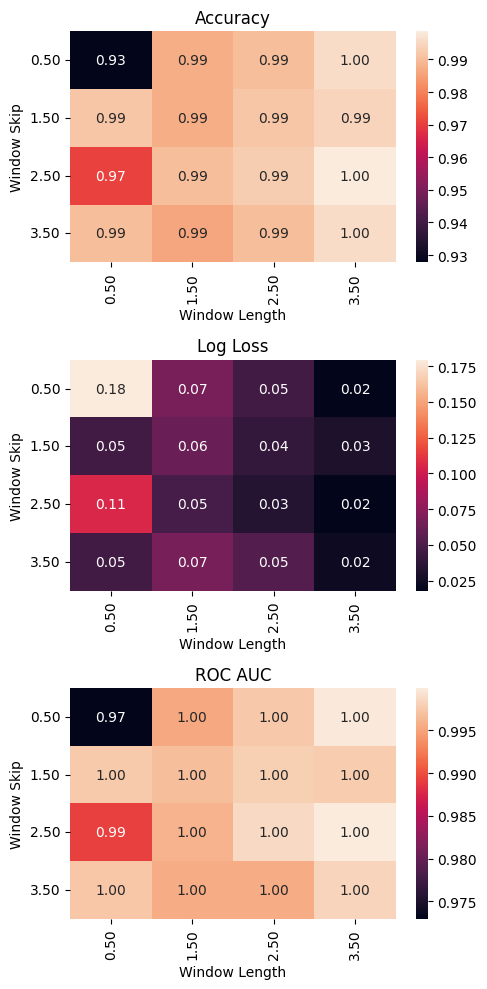

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import FormatStrFormatter

#winskips = [f"{ws:.2f}" for ws, wl in options_matrix]
#winlens = [f"{wl:.2f}" for ws, wl in options_matrix]
winskips = [f"{i}" for i in np.linspace(-6, 1, 4)]
winlens = [f"{i}" for i in np.linspace(-3, 1, 4)]

fig, ax = plt.subplots(3,1,figsize=(5,10))

#formatter = LogFormatter(10, labelOnlyBase=False)
formatter = FormatStrFormatter("%.2f")

sns.heatmap(np.array(accuracies).reshape(4,4),ax=ax[0],annot=True,fmt=".2f", xticklabels=winskips, yticklabels=winlens)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Window Length")
ax[0].set_ylabel("Window Skip")
ax[0].xaxis.set_major_formatter(formatter)
ax[0].yaxis.set_major_formatter(formatter)

sns.heatmap(np.array(log_losses).reshape(4,4),ax=ax[1],annot=True,fmt=".2f",xticklabels=winskips, yticklabels=winlens)
ax[1].set_title("Log Loss")
ax[1].set_xlabel("Window Length")
ax[1].set_ylabel("Window Skip")
ax[1].xaxis.set_major_formatter(formatter)
ax[1].yaxis.set_major_formatter(formatter)

sns.heatmap(np.array(roc_aucs).reshape(4,4),ax=ax[2],annot=True,fmt=".2f",xticklabels=winskips, yticklabels=winlens)
ax[2].set_title("ROC AUC")
ax[2].set_xlabel("Window Length")
ax[2].set_ylabel("Window Skip")
ax[2].xaxis.set_major_formatter(formatter)
ax[2].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()
